# Interest Rate

modified values from interest_rates.csv where the date is split into year and month for search and match purposes.

In [1]:
import pandas as pd

interest_rates_expanded = pd.read_csv('../data/interest_rates.csv')

# DATE info in format: YYYY-MM-DD
def get_year(date:str):
    return date.split('-')[0]

def get_month(date:str):
    return date.split('-')[1]

# add the YEAR and MONTH columns
interest_rates_expanded['YEAR'] = interest_rates_expanded['DATE'].apply(get_year)
interest_rates_expanded['MONTH'] = interest_rates_expanded['DATE'].apply(get_month)

# remove the redundant DATE column
interest_rates_expanded = interest_rates_expanded.drop(columns='DATE')

# sort by YEAR, MONTH so that the indexes are meaningful (higher index = later)
interest_rates_expanded.sort_values(by=['YEAR','MONTH'])

# convert the generated dataframe to a readable .csv file for future use
interest_rates_expanded.to_csv('../data/interest_rates_expanded.csv')

# superficially verify output
print(interest_rates_expanded)

     FEDFUNDS  YEAR MONTH
0        0.80  1954    07
1        1.22  1954    08
2        1.07  1954    09
3        0.85  1954    10
4        0.83  1954    11
..        ...   ...   ...
827      5.08  2023    06
828      5.12  2023    07
829      5.33  2023    08
830      5.33  2023    09
831      5.33  2023    10

[832 rows x 3 columns]


### Implement and incorporate Interest Rate Feature
Actually process the base data and find the correlating interest rate for each loan based on approval date

In [2]:
# read the base values
SBA_vals = pd.read_csv('../data/df_clean.csv')

# the format for a ApprovalDate is DD-mmm-YY where 'mmm' is a 3-char string that represents the month (e.g.: 'Jan', 'Feb', 'Oct',etc.)
# in order to find the interest rate at time of Approval, this format will need to be changed to be consistent with the YEAR MONTH 
# values above

months = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
def pull_fixed_YEAR_MONTH_SBAdata(date:str):
    day,month,year = date.split('-')

    #fix the month
    month = months[month]

    #fix the year
    year = '19' + year if year > '30' else '20' + year

    return month, year

# now that we can extract appropriate/standardized month/year information
# we will add a new column that is the interest rate based on the information
# in the SBA_vals['ApprovalDate'] column

def get_interest_rate_from_ApprovalDate(date:str):
    month,year = pull_fixed_YEAR_MONTH_SBAdata(date)
    
    interest_rate = interest_rates_expanded[(interest_rates_expanded['YEAR'] == year) & (interest_rates_expanded['MONTH'] == month)]

    return interest_rate['FEDFUNDS'].iloc[0] if not interest_rate.empty else None


# sample set and demonstrate it works for a given sample
# SBA_sample = SBA_vals.sample(20)
# SBA_sample['InterestRate'] = SBA_sample['ApprovalDate'].apply(get_interest_rate_from_ApprovalDate)

# print(SBA_sample[['ApprovalDate','InterestRate']])

SBA_vals['InterestRate'] = SBA_vals['ApprovalDate'].apply(get_interest_rate_from_ApprovalDate)

print(SBA_vals.sample(20))

/var/folders/41/hgg8f6_j1dj4y4mt0w22d8ym0000gn/T/ipykernel_84013/465892043.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  SBA_vals = pd.read_csv('../data/df_clean.csv')


        LoanNr_ChkDgt                            Name              City State  \
687537     7365833006               GLENN'S ALIGNMENT           TEKAMAH    NE   
132530     2008565010  KANSAS CITY HEALTH SYSTEMS, IN       LEES SUMMIT    MO   
723196     7751164000  VALLEY MEDICAL EQUIPMENT, INC.     BARBOURSVILLE    WV   
776234     8608224007     KID'S WORLD LEARNING CENTER            WILLIS    TX   
63671      1503735005               Appraisal Express  LAKE HAVASU CITY    AZ   
47722      1387185008                  Manicolor Inc.           Paramus    NJ   
522938     5277414006  ROCKY MOUNTAIN CABINET & MILLW       IDAHO FALLS    ID   
174242     2288416000     LIBERTY PETROLEUM TRANSPORT           ONTARIO    CA   
370741     3696474008     COBBLER'S BAKE SHOPPE, INC.         MIDDLETON    MA   
683634     7321513002          NORWOOD CLEANERS, INC.           NORWOOD    MA   
477269     4752063007  KENNETH & JOY STOVCIK DDS,INC.        THORNVILLE    OH   
263565     2898435007  Out o

In [3]:
# SBA_vals[['ApprovalDate', 'InterestRate']].sample(10)
SBA_vals.to_csv('../data/df_encoded_with_interest_rate.csv',index=False)

# Engineering ApprovalDate-derivative-features
## Outlier Years (number of loans)

There are years where the SBA was just getting established and the overall number of loans for that period of time are non-representative of the overall data. For the sake of clarity, the years where this is the case will be extracted to a csv file for later reference in order to remove loans that were made in these odd years.

loans_in_year check
min year: 1961	max year: 2014


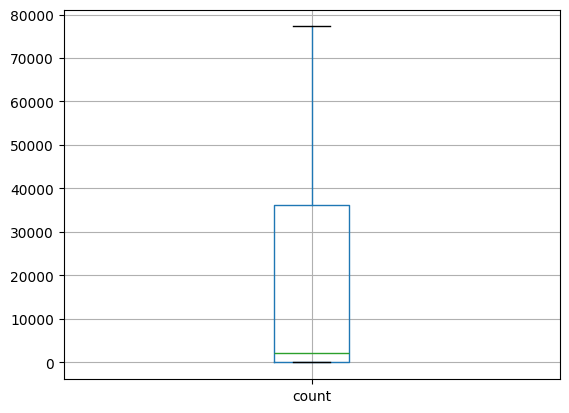

In [4]:
# read the SBA data
SBA_data = pd.read_csv('../data/SBAnational.csv', low_memory=False)

# format for a date: DD-mmm-YY where 'mmm' is a 3-char string representing the month (ex: Sep, Aug, Jun)
# the year needs to be fixed, because as a 2-digit string '99' comes after '06'; needs to be expanded to 4-digit version

# function returns cleaned year value
def extract_year(date:str):
    # parse date information
    day,month,year = date.split('-')

    # clean year
    year = int('19' + year) if year > '30' else int('20' + year)

    return year


# apply the cleaning function to the dataframe
loans_in_year = SBA_data['ApprovalDate'].apply(extract_year)

print('loans_in_year check')
print(f'min year: {loans_in_year.min()}\tmax year: {loans_in_year.max()}')

loans_in_year = loans_in_year.value_counts()

loans_in_year.describe()

import matplotlib.pyplot as plt

pd.DataFrame(loans_in_year).boxplot()
plt.show()



# outlier_years = pd.DataFrame(columns=['YEAR','LOANS'])

# some of the ApprovalDates are strings - specifically in a 1976 where there was a lot of fraud;
# since these will automatically be removed later, these values should be automatically added to the list of years